In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import shutil

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

from utils.show_grid import show_grid
from utils.augment import CutMix
from train import train_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [4]:
BASE_LOG_DIR = os.path.join(os.getcwd(), "tboard_logs")

os.makedirs(BASE_LOG_DIR, exist_ok=True)

## Augmentations

In [5]:
from dataset import PersonRobotDataset

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# the value for the split are found manually to have 150 pictures of each class in training
dataset = PersonRobotDataset("images", train_ratio=.837, train_transform=data_transforms['train'], val_transform=data_transforms['val'])

cutmix_transform = CutMix()
train_loader = dataset.train_dataloader(collate_fn=cutmix_transform)
val_loader = dataset.val_dataloader()

Training set size: 300 images
Validation set size: 60 images


/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


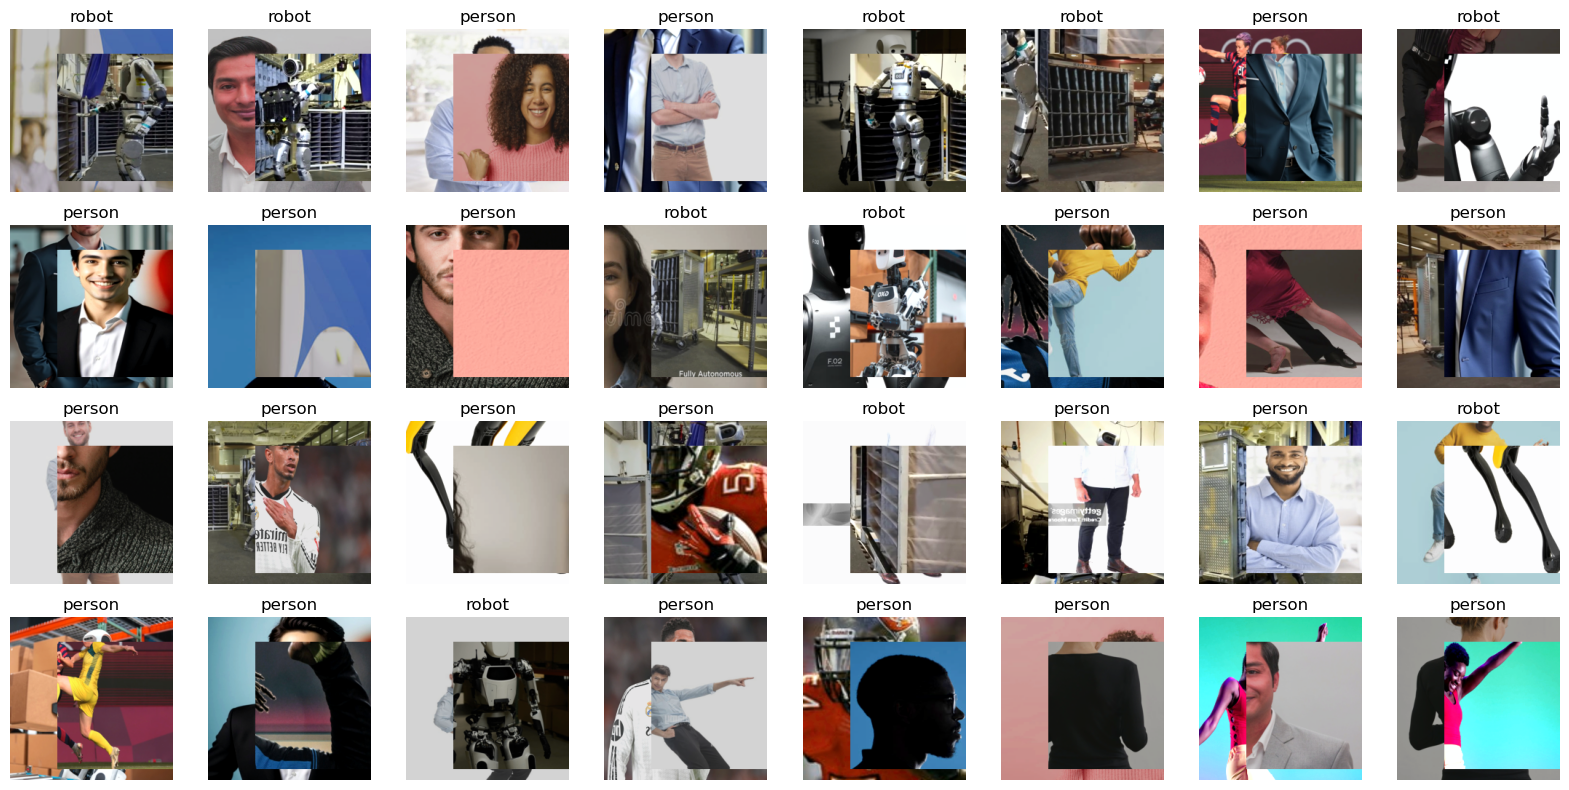

In [6]:
class_names = dataset.train_dataset.dataset.classes
inputs, classes = next(iter(train_loader))
titles = [class_names[1-int(x <= 0.5)] for x in classes]        
show_grid(inputs, titles)

In [23]:
inputs[10].size()

torch.Size([3, 224, 224])

## Training

In [7]:
from utils.seed import set_random_seed

set_random_seed()

### ResNet

In [8]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256, 1)
)
resnet_model.to(device)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [10]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ResNet_tuned2")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [11]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=resnet_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=20, device=device, logger=writer.add_scalar
    )

  0%|          | 0/20 [00:00<?, ?it/s]

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  5%|▌         | 1/20 [00:03<01:04,  3.37s/it]

Epoch 1/20
    Train loss: 0.5587
    Valid loss: 0.70032
    Accuracy: 58.333333333333336%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 2/20 [00:06<01:00,  3.37s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 15%|█▌        | 3/20 [00:09<00:55,  3.25s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 4/20 [00:13<00:53,  3.33s/it]/home/user/kellerv1/miniforge3/envs/lab/li

Epoch 6/20
    Train loss: 0.40242
    Valid loss: 0.09253
    Accuracy: 98.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 35%|███▌      | 7/20 [00:22<00:41,  3.20s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████      | 8/20 [00:25<00:37,  3.13s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 45%|████▌     | 9/20 [00:28<00:34,  3.13s/it]/home/user/kellerv1/miniforge3/envs/lab/li

Epoch 11/20
    Train loss: 0.35226
    Valid loss: 0.08825
    Accuracy: 98.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|██████    | 12/20 [00:37<00:24,  3.02s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 65%|██████▌   | 13/20 [00:40<00:20,  2.96s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045

Epoch 16/20
    Train loss: 0.3373
    Valid loss: 0.08482
    Accuracy: 98.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 85%|████████▌ | 17/20 [00:53<00:09,  3.08s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 90%|█████████ | 18/20 [00:56<00:06,  3.18s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045

Epoch 20/20
    Train loss: 0.43571
    Valid loss: 0.08467
    Accuracy: 98.33333333333333%


Training completed


### ConvNext

In [47]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ConvNext_tuned")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [50]:
convnext_model = models.convnext_tiny(pretrained=True)
num_ftrs = convnext_model.classifier[2].in_features
convnext_model.classifier[2] = nn.Linear(num_ftrs, 1)
convnext_model.to(device)
print(convnext_model.classifier)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1, bias=True)
)


In [51]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnext_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [52]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=convnext_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=10, device=device, logger=writer.add_scalar
    )

  0%|          | 0/20 [00:00<?, ?it/s]

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  5%|▌         | 1/20 [00:03<01:00,  3.21s/it]

Epoch 1/20
    Train loss: 0.52376
    Valid loss: 0.74977
    Accuracy: 48.333333333333336%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 2/20 [00:06<01:03,  3.53s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 15%|█▌        | 3/20 [00:11<01:04,  3.82s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/20
    Train loss: 0.29488
    Valid loss: 0.06373
    Accuracy: 100.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 35%|███▌      | 7/20 [00:26<00:47,  3.65s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████      | 8/20 [00:29<00:42,  3.54s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 11/20
    Train loss: 0.32079
    Valid loss: 0.04905
    Accuracy: 100.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|██████    | 12/20 [00:43<00:28,  3.59s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 65%|██████▌   | 13/20 [00:47<00:24,  3.56s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045

Epoch 16/20
    Train loss: 0.36239
    Valid loss: 0.04663
    Accuracy: 100.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 85%|████████▌ | 17/20 [01:02<00:10,  3.67s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 90%|█████████ | 18/20 [01:05<00:07,  3.52s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045

Epoch 20/20
    Train loss: 0.3624
    Valid loss: 0.04688
    Accuracy: 100.0%


Training completed


### EfficientNet

In [53]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "EfficientNet_tuned")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [58]:
efficient_model = models.efficientnet_b0(pretrained=True)
num_ftrs = efficient_model.classifier[1].in_features
efficient_model.classifier[1] = nn.Linear(num_ftrs, 1)
efficient_model.to(device)
print(efficient_model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1, bias=True)
)


In [59]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [60]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=efficient_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=20, device=device, logger=writer.add_scalar
    )

  0%|          | 0/20 [00:00<?, ?it/s]

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  5%|▌         | 1/20 [00:03<00:57,  3.03s/it]

Epoch 1/20
    Train loss: 0.6293
    Valid loss: 0.67226
    Accuracy: 68.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 2/20 [00:06<00:55,  3.09s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 15%|█▌        | 3/20 [00:09<00:55,  3.26s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/20
    Train loss: 0.42991
    Valid loss: 0.12001
    Accuracy: 98.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 35%|███▌      | 7/20 [00:22<00:41,  3.23s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████      | 8/20 [00:26<00:39,  3.32s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 11/20
    Train loss: 0.3534
    Valid loss: 0.12877
    Accuracy: 98.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|██████    | 12/20 [00:39<00:26,  3.27s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 65%|██████▌   | 13/20 [00:42<00:22,  3.23s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045

Epoch 16/20
    Train loss: 0.41414
    Valid loss: 0.12378
    Accuracy: 98.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 85%|████████▌ | 17/20 [00:55<00:10,  3.38s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 90%|█████████ | 18/20 [00:58<00:06,  3.23s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045

Epoch 20/20
    Train loss: 0.34183
    Valid loss: 0.12125
    Accuracy: 98.33333333333333%


Training completed
